In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/apple/anaconda3/envs/DeepLearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/apple/anaconda3/envs/DeepLearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Network

In [2]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

In [11]:

graph=tf.Graph()


In [12]:
logs_dir = './graphs/'
batch_size=128
num_steps=365
lstm_layers= 1
lstm_size= 10
inputs_dim= 1
alpha = 0.1

In [13]:
with graph.as_default():
    inputs_ = tf.placeholder( tf.float32, [batch_size,num_steps, inputs_dim] , name='inputs')
    targets_ = tf.placeholder( tf.float32, [batch_size,num_steps, inputs_dim] , name='targets')
    learning_rate= tf.placeholder( tf.float32 , name='lr')
    grad_clip= tf.placeholder( tf.float32 , name='clip')

In [14]:

with graph.as_default():
    rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)

# 'outputs' is a tensor of shape [batch_size, max_time, cell_state_size]

# defining initial state
    initial_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)

# 'state' is a tensor of shape [batch_size, cell_state_size]
    outputs, state = tf.nn.dynamic_rnn(rnn_cell, inputs_,
                                   initial_state=initial_state,
                                   dtype=tf.float32)
    W = tf.Variable(tf.random_normal([lstm_size, inputs_dim]), dtype=tf.float32) # weights
    b = tf.Variable(tf.random_normal([ inputs_dim]), dtype=tf.float32) # biases
    shape = outputs.shape
    
    outputs = tf.matmul( tf.reshape( outputs, [-1, lstm_size]), W ) + b
    outputs = tf.reshape( outputs, (shape[0],shape[1],b.shape[0]))

In [15]:
with graph.as_default():
    cost = tf.losses.mean_squared_error( outputs , targets_)
    optimizer= build_optimizer(cost, learning_rate, grad_clip)
    

## Batch

In [16]:
#constant trend
def batch_1(batch_size, num_steps):
    trend = np.zeros( num_steps+1)
    trend = np.reshape( trend, [-1,1])
    while True:
        batch = np.random.randn( batch_size,num_steps+1,1)
        for i in range(batch_size):
            batch[i,:,:]=batch[i,:,:]+trend[:,:]
        
        yield (batch[:,:-1,:] , batch[:,1:,:] )
#sin trend
def batch_2(batch_size, num_steps):
    trend = np.arange( num_steps+1)
    trend = np.sin(trend)
    trend = np.reshape( trend, [-1,1])
    while True:
        batch = np.random.randn( batch_size,num_steps+1,1)
        for i in range(batch_size):
            batch[i,:,:]=batch[i,:,:]+trend[:,:]
        
        yield (batch[:,:-1,:] , batch[:,1:,:] )
    

In [17]:
generator1 = batch_1(batch_size, num_steps )

In [18]:
generator2 = batch_2(batch_size, num_steps)

In [19]:
generator= generator2

## Training

In [20]:
writer = tf.summary.FileWriter(logs_dir, graph)
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        X,Y = next(generator)
        state = sess.run( initial_state)
        variables =tf.trainable_variables()
        feed = { inputs_: X,
                initial_state :state,
               targets_: Y ,
               learning_rate: 0.1,
               grad_clip: 0.1}
        sess.run( [optimizer], feed_dict=feed)
        result = sess.run( [cost, outputs], feed_dict=feed)
        if (i+1) %100 == 0 :
            print( result[0]-1)
        if (i+1)%1000 == 0 :
            print( outputs[0,])
writer.close()   

0.07737171649932861
0.06720805168151855
0.044841766357421875
0.044959306716918945
0.05106663703918457
0.01763176918029785
0.021300792694091797
0.008748888969421387
0.015498757362365723
0.021294116973876953
Tensor("strided_slice:0", shape=(365, 1), dtype=float32)


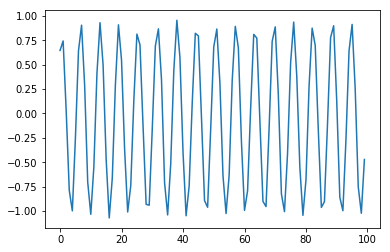

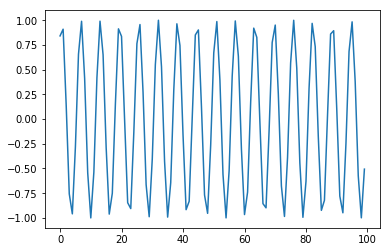

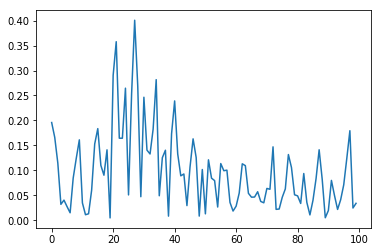

In [23]:
trend = np.arange( num_steps+1)
trend = np.sin(trend)
n= 100
plt.plot( result[1][0,0:n,0] )
plt.show()
plt.plot( trend[1:n+1])
plt.show()
plt.plot( np.abs(result[1][0,0:n,0] -trend[1:n+1] ) )
plt.show()